# A template notebook to compute network motifs from a GRN

## Goals

### - 1) run mFinder from Uri Alon's lab
### - 2) extract the network motif scores
### - 3) extract the nodes (genes) corresponding to each network motif, save as a dataframe.

### NOTES
- mFinder is a package to compute network motifs, a pattern of motifs that is over-represented than randomly permuted network.

- Designed for Windows machine, but can run on Linux environment.
- mfinder 1.21 is used here.

- **EDIT**: we wrote a set of python scripts to process the GRN and run mFinder for each cell-type to compute the network motifs. Then, another python script to extract the corresponding "nodes"(genes) from the GRN for each network motif, then save as a master dataframe. 

Last updated: 11/26/2023

Author: Yang-Joon Kim



In [1]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [19]:
import celloracle as co
co.__version__

'0.14.0'

In [20]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Step 1. run mFinder for all cell-types (for one Links object)

## NOTES:
- 1) We're not looping over timepoints for now.
- 2) The command below should run on "celloracle_env" conda environment when wrapped around in snakemake.

In [3]:
sys.path.append("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/scripts/")

In [29]:
# run the python wrapper for mFinder (run_mFinder_GRNs.py)
# sample: TDR119
os.system("python /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/scripts/run_mFinder_GRNs.py \
            --inputpath /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/ \
            --name 08_TDR119_celltype_GRNs.celloracle.links \
            --mfinder /hpc/projects/data.science/yangjoon.kim/github_repos/mfinder/mfinder1.21/ \
            --outputpath /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/07_TDR119_celloracle_GRN/")

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

Input Network file is filtered_GRN_Adaxial_Cells_mfinder_format.txt
mfinder Version 1.20

Loading Network
	Reading Network file in <Source,Target,Weight> Format
Searching motifs size 3
Processing Real network...

 (Real network processing runtime was:    1.0 seconds.)
Processing Random networks
..........
 Estimated run time left :     27 seconds.

..........
 Estimated run time left :     24 seconds.

..........
 Estimated run time left :     21 seconds.

..........
 Estimated run time left :     18 seconds.

..........
 Estimated run time left :     15 seconds.

..........
 Estimated run time left :     12 seconds.

..........
 Estimated run time left :      9 seconds.

..........
 Estimated run time left :      6 seconds.

..........
 Estimated run time left :      3 seconds.

..........
 Estimated run time left :      0 seconds.


Calculating Results...

MOTIF FINDER RESULTS:

	Network name: filtered_GRN_Adaxial_Cells_mfinder_format.txt
	Network type: Directed
	Num of Nodes: 466 Nu

0

## Step 2. extract nodes(genes) for corresponding motifs

In [ ]:
sys.path.append("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/scripts/")

In [15]:
# import custom functions from network_motifs module (custom)
from module_network_motifs import extract_motif_info, extract_gene_names_for_motifs, get_adjacency_matrix

## Step 2-1. Extract the motif information from a GRN as a dataframe

In [39]:
# Step 2-1. Extract the motif information from a GRN

# define the filepath where all the mFinder output files are saved
mfinder_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/07_TDR119_celloracle_GRN/"

# define the master dataframe
df_motifs_all = pd.DataFrame(columns=['MOTIF_ID', 'NREAL', 'NRAND_STATS', 'NREAL_ZSCORE', 'NREAL_PVAL',
       'UNIQ_VAL', 'CREAL_[MILI]', 'motifs', 'timepoint', 'cell-type'])

# Step 1. List all motif files (mFinder output text files)
all_files = os.listdir("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/07_TDR119_celloracle_GRN/")

filtered_files = [f for f in all_files if 'motifs' in f]
print(f"Number of files containing 'motifs': {len(filtered_files)}")
filtered_files.sort() # sort numerically (timepoints), and alphabetically (cell-types)

# extract the celltypes
celltypes = [name.split('motifs_')[1].split('_OUT')[0] for name in filtered_files]
celltypes

# Step 2. extract the motif information, concatenate into the master dataframe

for index, filename in enumerate(filtered_files):
    # extract the motif information
    df_temp = extract_motif_info(mfinder_output_path + filename)
    
    # Add cell-types into the dataframe
    df_temp["timepoint"] = "15somites"
    df_temp["cell-type"] = celltypes[index]

    # Append the dataframe to the master dataframe
    df_motifs_all = df_motifs_all.append(df_temp)


df_motifs_all


df_motifs_all.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/df_network_motifs_TDR119.csv")

Number of files containing 'motifs': 14


,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
0,38,828,616.0+-35.8,5.92,0.000,20,22.54,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
1,46,91,48.7+-6.2,6.79,0.000,4,2.48,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
0,108,16,4.2+-1.9,6.05,0.000,4,0.43,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Differentiating_Neurons
0,38,822,640.2+-36.1,5.04,0.000,17,19.12,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,NMPs
1,46,75,51.1+-7.1,3.39,0.000,5,1.74,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,NMPs
2,108,33,8.6+-2.6,9.37,0.000,4,0.77,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,NMPs
0,108,14,7.9+-2.8,2.15,0.010,4,0.33,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Neural_Crest
0,38,619,351.4+-24.1,11.11,0.000,23,17.10,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Notochord
1,46,20,11.3+-3.4,2.55,0.010,5,0.55,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Notochord
0,110,24,10.2+-3.3,4.20,0.000,4,0.57,"[[0, 1, 1], [1, 0, 1], [1, 0, 0]]",15somites,PSM


In [40]:
df_motifs_all.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/df_network_motifs_TDR119.csv")

In [45]:
df_motifs_all.groupby("cell-type").size()

cell-type
Adaxial_Cells              2
Differentiating_Neurons    1
NMPs                       3
Neural_Crest               1
Notochord                  2
PSM                        1
Somites                    2
dtype: int64

In [46]:
df_motifs_all.groupby("MOTIF_ID").size()

MOTIF_ID
102    1
108    4
110    1
38     3
46     3
dtype: int64

## Step 2-2. Extract the gene_names (nodes) for corresponding motifs from each GRN (timepoint, cell-type)

- Now that we have the master dataframe for MOTIF_IDs for all timepoints and cell-types, we wanted to extract the nodes (gene_names) corresponding to each MOTIF_ID for each timepoint, and cell-type, then save as a dataframe (one .csv file for each timepoint, and cell-type)?

- Alternatively, we can create another master dataframe, showing the triplet of gene_names, with "timepoint", and "cell-type" as column identifiers.

In [52]:
df_motifs_all

,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
0,38,828,616.0+-35.8,5.92,0.000,20,22.54,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
1,46,91,48.7+-6.2,6.79,0.000,4,2.48,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
0,108,16,4.2+-1.9,6.05,0.000,4,0.43,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Differentiating_Neurons
0,38,822,640.2+-36.1,5.04,0.000,17,19.12,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,NMPs
1,46,75,51.1+-7.1,3.39,0.000,5,1.74,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,NMPs
2,108,33,8.6+-2.6,9.37,0.000,4,0.77,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,NMPs
0,108,14,7.9+-2.8,2.15,0.010,4,0.33,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Neural_Crest
0,38,619,351.4+-24.1,11.11,0.000,23,17.10,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Notochord
1,46,20,11.3+-3.4,2.55,0.010,5,0.55,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Notochord
0,110,24,10.2+-3.3,4.20,0.000,4,0.57,"[[0, 1, 1], [1, 0, 1], [1, 0, 0]]",15somites,PSM


In [53]:
df_motifs_all["motifs"]

0    [[0, 1, 1], [0, 0, 1], [0, 0, 0]]
1    [[0, 1, 1], [1, 0, 1], [0, 0, 0]]
0    [[0, 0, 1], [1, 0, 1], [1, 0, 0]]
0    [[0, 1, 1], [0, 0, 1], [0, 0, 0]]
1    [[0, 1, 1], [1, 0, 1], [0, 0, 0]]
2    [[0, 0, 1], [1, 0, 1], [1, 0, 0]]
0    [[0, 0, 1], [1, 0, 1], [1, 0, 0]]
0    [[0, 1, 1], [0, 0, 1], [0, 0, 0]]
1    [[0, 1, 1], [1, 0, 1], [0, 0, 0]]
0    [[0, 1, 1], [1, 0, 1], [1, 0, 0]]
0    [[0, 1, 1], [0, 0, 1], [1, 0, 0]]
1    [[0, 0, 1], [1, 0, 1], [1, 0, 0]]
Name: motifs, dtype: object

In [57]:
# for index, motif in enumerate(df_motifs_all["motifs"]):
#     print(index, motif)

0 [[0 1 1]
 [0 0 1]
 [0 0 0]]
1 [[0 1 1]
 [1 0 1]
 [0 0 0]]
2 [[0 0 1]
 [1 0 1]
 [1 0 0]]
3 [[0 1 1]
 [0 0 1]
 [0 0 0]]
4 [[0 1 1]
 [1 0 1]
 [0 0 0]]
5 [[0 0 1]
 [1 0 1]
 [1 0 0]]
6 [[0 0 1]
 [1 0 1]
 [1 0 0]]
7 [[0 1 1]
 [0 0 1]
 [0 0 0]]
8 [[0 1 1]
 [1 0 1]
 [0 0 0]]
9 [[0 1 1]
 [1 0 1]
 [1 0 0]]
10 [[0 1 1]
 [0 0 1]
 [1 0 0]]
11 [[0 0 1]
 [1 0 1]
 [1 0 0]]


In [ ]:
# Step 2-2. Extract the corresponding nodes (genes) for each network motif
path_GRN = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links"

df_motifs = 
file

for index, motif in enumerate(df_motifs_all["motifs"]):
    df_motifs_all
    celltype = 
    

extract_gene_names_for_motifs()




In [70]:
df_motifs_all = df_motifs_all.reset_index(drop=True)
df_motifs_all

,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
0,38,828,616.0+-35.8,5.92,0.000,20,22.54,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
1,46,91,48.7+-6.2,6.79,0.000,4,2.48,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Adaxial_Cells
2,108,16,4.2+-1.9,6.05,0.000,4,0.43,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Differentiating_Neurons
3,38,822,640.2+-36.1,5.04,0.000,17,19.12,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,NMPs
4,46,75,51.1+-7.1,3.39,0.000,5,1.74,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,NMPs
5,108,33,8.6+-2.6,9.37,0.000,4,0.77,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,NMPs
6,108,14,7.9+-2.8,2.15,0.010,4,0.33,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Neural_Crest
7,38,619,351.4+-24.1,11.11,0.000,23,17.10,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",15somites,Notochord
8,46,20,11.3+-3.4,2.55,0.010,5,0.55,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",15somites,Notochord
9,110,24,10.2+-3.3,4.20,0.000,4,0.57,"[[0, 1, 1], [1, 0, 1], [1, 0, 0]]",15somites,PSM


In [79]:
def extract_gene_names_for_motif(GRN_celltype, motif, motif_id, filepath_output):

    # Convert the dataframe into a set of directed edges for easy querying
    edges = set(tuple(row) for row in GRN_celltype[['source', 'target']].values)

    # Define your motifs
    #motif_matrices = df_motifs["motifs"]
    #motif_matrices = [
    #    [[0, 1, 1], [1, 0, 1], [0, 0, 0]],
    #    [[0, 0, 1], [1, 0, 1], [1, 0, 0]],
    #    [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
    #]

    # Union of unique 'source' and 'target' nodes
    all_unique_nodes = set(GRN_celltype['source'].unique()).union(set(GRN_celltype['target'].unique()))

    # Check each triplet in the GRN against the motifs
    instances = {}
    instances[motif_id] = []
    for triplet in combinations(all_unique_nodes, 3):
        matrix = get_adjacency_matrix(triplet, edges)
        if matrix == motif:
            instances[motif_id].append(triplet)
                
    # Convert instances into a dataframe
    rows = []
    rows.append({'MOTIF_ID': motif_id, 'INSTANCE': instances[motif_id]})
    # for idx, instance_list in instances.items():
    #     for instance in instance_list:
    #         rows.append({'MOTIF_ID': idx, 'INSTANCE': instance})
    

    instances_df = pd.DataFrame(rows)

    #print(instances_df)
    # replace the indices of instances_df to "MOTIF_ID"
    dict_motif_id = dict(zip(instances_df["MOTIF_ID"].unique(), df_motifs["MOTIF_ID"]))
    instances_df.MOTIF_ID = instances_df.MOTIF_ID.map(dict_motif_id)
    
    return instances_df

In [82]:
from itertools import combinations

In [83]:
# A function to extract the gene_names from a GRN for a corresponding network motif
# This function takes a GRN, and a single motif, and returns a dataframe of instances of nodes/edges in the GRN

# (Prerequisite) Load your GRN object (Links object) from the celloracle output
filepath_GRN = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links"
GRN = co.load_hdf5(filepath_GRN)
# define the celltype
celltype = "Somites" # or "NMPs", "Neural_Crest", etc.
GRN_celltype = GRN.filtered_links[celltype]
# define the motif and motif_id
index = 0
motif = df_motifs_all.iloc[index].motifs
motif_id =  df_motifs_all.iloc[index].MOTIF_ID


In [84]:
GRN_celltype

,source,target,coef_mean,coef_abs,p,-logp
153976,hmga1a,rpl7a,0.272201,0.272201,8.689711e-20,19.060995
165686,hmga1a,si:ch73-281n10.2,0.251827,0.251827,1.634310e-17,16.786666
79718,hmga1a,hmgb2b,0.158835,0.158835,7.677444e-19,18.114783
118636,hmga1a,ncl,0.156625,0.156625,1.022828e-19,18.990197
84759,hmga1a,hsp90ab1,0.150259,0.150259,2.659047e-21,20.575274
...,...,...,...,...,...,...
127294,pitx3,nrp2b,0.017555,0.017555,1.250992e-12,11.902745
73943,tlx2,h3f3d,-0.017551,0.017551,2.969473e-07,6.527321
184918,nr2f1b,tenm3,0.017548,0.017548,8.461343e-08,7.072561
112968,cdx4,msgn1,0.017539,0.017539,2.845028e-10,9.545913


In [92]:
edges = set(tuple(row) for row in GRN_celltype[['source', 'target']].values)

all_unique_nodes = set(GRN_celltype['source'].unique()).union(set(GRN_celltype['target'].unique()))


# Check each triplet in the GRN against the motifs
instances = {}
instances[motif_id] = []
for triplet in combinations(all_unique_nodes, 3):
    matrix = get_adjacency_matrix(triplet, edges)
    if matrix == motif:
        instances[motif_id].append(triplet)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Convert the dataframe into a set of directed edges for easy querying
edges = set(tuple(row) for row in GRN_celltype[['source', 'target']].values)

# Union of unique 'source' and 'target' nodes
all_unique_nodes = set(GRN_celltype['source'].unique()).union(set(GRN_celltype['target'].unique()))

# Check each triplet in the GRN against the motifs
instances = {}
instances[motif_id] = []
for triplet in combinations(all_unique_nodes, 3):
    matrix = get_adjacency_matrix(triplet, edges)
    if matrix == motif:
        instances[motif_id].append(triplet)

# Convert instances into a dataframe
rows = []
rows.append({'MOTIF_ID': motif_id, 'INSTANCE': instances[motif_id]})
# for idx, instance_list in instances.items():
#     for instance in instance_list:
#         rows.append({'MOTIF_ID': idx, 'INSTANCE': instance})


instances_df = pd.DataFrame(rows)

#print(instances_df)
# replace the indices of instances_df to "MOTIF_ID"
dict_motif_id = dict(zip(instances_df["MOTIF_ID"].unique(), df_motifs["MOTIF_ID"]))
instances_df.MOTIF_ID = instances_df.MOTIF_ID.map(dict_motif_id)

return instances_df

In [85]:
# extract the nodes (genes) for a single motif
instances_df = extract_gene_names_for_motif(GRN_celltype, motif, motif_id, filepath_output="")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [63]:
df_motifs_all["MOTIF_ID"]

for index, value in enumerate(df_motifs_all["MOTIF_ID"]):
    print(index, value)
    
    

0 38
1 46
2 108
3 38
4 46
5 108
6 108
7 38
8 46
9 110
10 102
11 108


## load the GRN

In [148]:
filepath_GRN = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links"
GRN = co.load_hdf5(filepath_GRN)

In [93]:
celltype = "Somites"
GRN_celltype = GRN.filtered_links[celltype]
GRN_celltype

,source,target,coef_mean,coef_abs,p,-logp
153976,hmga1a,rpl7a,0.272201,0.272201,8.689711e-20,19.060995
165686,hmga1a,si:ch73-281n10.2,0.251827,0.251827,1.634310e-17,16.786666
79718,hmga1a,hmgb2b,0.158835,0.158835,7.677444e-19,18.114783
118636,hmga1a,ncl,0.156625,0.156625,1.022828e-19,18.990197
84759,hmga1a,hsp90ab1,0.150259,0.150259,2.659047e-21,20.575274
...,...,...,...,...,...,...
127294,pitx3,nrp2b,0.017555,0.017555,1.250992e-12,11.902745
73943,tlx2,h3f3d,-0.017551,0.017551,2.969473e-07,6.527321
184918,nr2f1b,tenm3,0.017548,0.017548,8.461343e-08,7.072561
112968,cdx4,msgn1,0.017539,0.017539,2.845028e-10,9.545913


In [94]:
source_nodes = set(GRN_celltype.source)
target_nodes = set(GRN_celltype.target)

In [95]:
gene_nodes = source_nodes|target_nodes 
len(gene_nodes)

463

In [96]:
print(len(source_nodes))
print(len(target_nodes))
print(len(source_nodes & target_nodes))
print(len(source_nodes | target_nodes))

265
237
39
463


In [97]:
GRN_celltype

,source,target,coef_mean,coef_abs,p,-logp
153976,hmga1a,rpl7a,0.272201,0.272201,8.689711e-20,19.060995
165686,hmga1a,si:ch73-281n10.2,0.251827,0.251827,1.634310e-17,16.786666
79718,hmga1a,hmgb2b,0.158835,0.158835,7.677444e-19,18.114783
118636,hmga1a,ncl,0.156625,0.156625,1.022828e-19,18.990197
84759,hmga1a,hsp90ab1,0.150259,0.150259,2.659047e-21,20.575274
...,...,...,...,...,...,...
127294,pitx3,nrp2b,0.017555,0.017555,1.250992e-12,11.902745
73943,tlx2,h3f3d,-0.017551,0.017551,2.969473e-07,6.527321
184918,nr2f1b,tenm3,0.017548,0.017548,8.461343e-08,7.072561
112968,cdx4,msgn1,0.017539,0.017539,2.845028e-10,9.545913


In [99]:
df_motifs_all[df_motifs_all["cell-type"]=="Somites"]

,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
10,102,14,5.5+-2.5,3.39,0.000,4,0.34,"[[0, 1, 1], [0, 0, 1], [1, 0, 0]]",15somites,Somites
11,108,28,9.4+-3.4,5.41,0.000,6,0.69,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",15somites,Somites


In [100]:
# From ChatGPT

# Load your GRN dataframe
# df = pd.read_csv("path_to_your_GRN.csv")  # replace with your file path
df = GRN_celltype

# Convert the dataframe into a set of directed edges for easy querying
edges = set(tuple(row) for row in df[['source', 'target']].values)


#df_motifs[['MOTIF_ID', 'motifs']]

# Define your motifs
# motif_matrices = [
#     [[0, 1, 1], [1, 0, 1], [0, 0, 0]],
#     [[0, 0, 1], [1, 0, 1], [1, 0, 0]],
#     [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
# ]

motif_matrices = [
    [[0, 1, 1], [0, 0, 1], [1, 0, 0]],
    [[0, 0, 1], [1, 0, 1], [1, 0, 0]],
]

# Function to get adjacency matrix for a triplet from the GRN
def get_adjacency_matrix(triplet, edges):
    matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            if (triplet[i], triplet[j]) in edges:
                matrix[i][j] = 1
    return matrix.tolist()

# # Check each triplet in the GRN against the motifs
# instances = {}
# for idx, motif in enumerate(motif_matrices):
#     instances[idx] = []

#     for triplet in combinations(df['source'].unique(), 3):
#         matrix = get_adjacency_matrix(triplet, edges)
#         if matrix == motif:
#             instances[idx].append(triplet)

# Union of unique 'source' and 'target' nodes
all_unique_nodes = set(df['source'].unique()).union(set(df['target'].unique()))

# Check each triplet in the GRN against the motifs
instances = {}
for idx, motif in enumerate(motif_matrices):
    instances[idx] = []

    for triplet in combinations(all_unique_nodes, 3):
        matrix = get_adjacency_matrix(triplet, edges)
        if matrix == motif:
            instances[idx].append(triplet)

# Convert instances into a dataframe
rows = []
for idx, instance_list in instances.items():
    for instance in instance_list:
        rows.append({'MOTIF_ID': idx, 'INSTANCE': instance})

instances_df = pd.DataFrame(rows)

print(instances_df)

   MOTIF_ID                  INSTANCE
0         0    (foxp4, sox11a, sox13)
1         0     (rxraa, nr2f5, gli2a)
2         0    (hoxb3a, nr2f5, gli2a)
3         0   (hoxb3a, nr2f5, arid3c)
4         1  (hoxc3a, hoxb6b, hoxc6b)
5         1      (foxp4, sox3, sox13)
6         1   (meis1b, hoxb3a, meox1)
7         1    (meis1b, nr2f5, meox1)


In [199]:
dict_motif_id = dict(zip(instances_df["MOTIF_ID"].unique(), df_motifs["MOTIF_ID"]))
dict_motif_id

instances_df.MOTIF_ID = instances_df.MOTIF_ID.map(dict_motif_id)
instances_df

,MOTIF_ID,INSTANCE
0,46,"(sox11b, hoxb3a, gadd45ba)"
1,46,"(raraa, hoxb6b, sulf1)"
2,46,"(raraa, hoxb6b, ripply2)"
3,46,"(raraa, hoxb6b, msgn1)"
4,46,"(raraa, hoxb6b, tob1a)"
...,...,...
325,238,"(lbx2, meox1, hoxc6b)"
326,238,"(lbx2, meox1, hoxb3a)"
327,238,"(lbx2, hoxc6b, hoxc3a)"
328,238,"(hoxc6b, hoxb7a, hoxb9a)"


In [203]:
instances_df.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/baseGRN_CisBP_RNA_zebrahub/10_extracted_nodes_motifs/motifs_node_genes_0budstage_Somites.csv")


### test

In [190]:
GRN_celltype[GRN_celltype.source.isin(["hoxc6b"])]

,source,target,coef_mean,coef_abs,p,-logp
196815,hoxc6b,mespaa,0.196897,0.196897,7.465155e-17,16.126961
196962,hoxc6b,mespab,0.146066,0.146066,1.072631e-13,12.969550
113871,hoxc6b,fn1a,0.140702,0.140702,2.977078e-17,16.526210
156109,hoxc6b,hoxc3a,0.109417,0.109417,1.386627e-17,16.858040
8743,hoxc6b,aldh1a2,0.105079,0.105079,8.696644e-15,14.060648
...,...,...,...,...,...,...
147163,hoxc6b,her2,0.042444,0.042444,8.353280e-13,12.078143
150082,hoxc6b,hhip,0.041315,0.041315,2.799864e-14,13.552863
154883,hoxc6b,hoxb6b,0.041053,0.041053,3.281597e-12,11.483915
196329,hoxc6b,meis2a,-0.040498,0.040498,2.947274e-18,17.530579


In [192]:
# Check the 3-size subgraph to make sure that we're detecting real motifs
GRN_celltype[GRN_celltype.source.isin(["hoxc6b","meox1","foxc1a"]) & GRN_celltype.target.isin(["hoxc6b","meox1","foxc1a"])]

,source,target,coef_mean,coef_abs,p,-logp
115685,meox1,foxc1a,0.111256,0.111256,1.320519e-16,15.879255
196659,hoxc6b,meox1,0.072215,0.072215,3.578723e-10,9.446272
115594,hoxc6b,foxc1a,0.055481,0.055481,1.162409e-09,8.934641
156420,meox1,hoxc6b,0.039263,0.039263,1.769696e-10,9.752101


## Step 3 (Optional). EDA on motif scores

- motif z-scores across cell-types, timepoints, etc.

In [334]:
df_motifs_all.head()

,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
0,46,590,419.3+-26.1,6.55,0.000,8,9.85,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",0budstage,Neural_Crest
0,38,1218,1080.1+-47.3,2.92,0.000,28,29.96,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",0budstage,Neural_Anterior
1,46,434,301.6+-19.2,6.90,0.000,20,10.67,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",0budstage,Neural_Anterior
2,108,113,64.4+-8.4,5.80,0.000,12,2.78,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",0budstage,Neural_Anterior
3,110,70,54.7+-7.1,2.15,0.020,10,1.72,"[[0, 1, 1], [1, 0, 1], [1, 0, 0]]",0budstage,Neural_Anterior


In [336]:
df_motifs_all.timepoint.unique()

array(['0budstage', '5somite', '10somite', '15somite', '20somite',
       '30somite'], dtype=object)

In [351]:
df_motifs_all[df_motifs_all.timepoint=="10somite"].head()

,MOTIF_ID,NREAL,NRAND_STATS,NREAL_ZSCORE,NREAL_PVAL,UNIQ_VAL,CREAL_[MILI],motifs,timepoint,cell-type
0,38,1737,1384.0+-59.4,5.94,0.000,26,40.03,"[[0, 1, 1], [0, 0, 1], [0, 0, 0]]",10somite,Neural_Crest
1,46,596,338.0+-18.2,14.21,0.000,17,13.74,"[[0, 1, 1], [1, 0, 1], [0, 0, 0]]",10somite,Neural_Crest
2,108,195,103.3+-11.0,8.32,0.000,9,4.49,"[[0, 0, 1], [1, 0, 1], [1, 0, 0]]",10somite,Neural_Crest
3,110,106,80.1+-8.8,2.94,0.000,9,2.44,"[[0, 1, 1], [1, 0, 1], [1, 0, 0]]",10somite,Neural_Crest
4,238,24,11.2+-3.3,3.86,0.000,5,0.55,"[[0, 1, 1], [1, 0, 1], [1, 1, 0]]",10somite,Neural_Crest


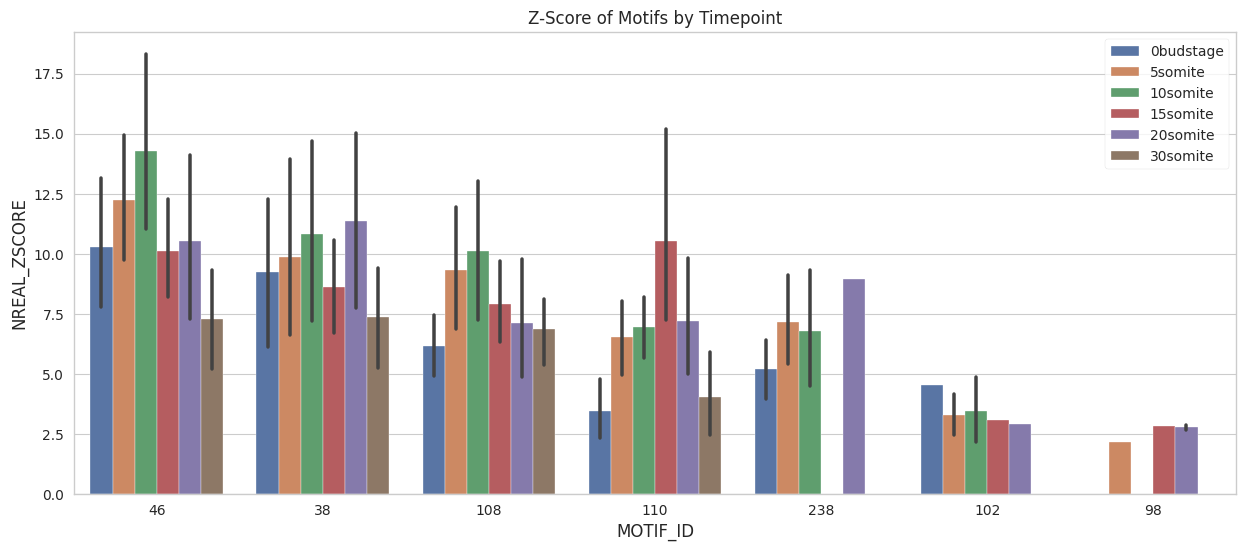

In [350]:
# A bar plot showing the Z-score of motifs for each motif for different timepoints
# convert the NREAL_ZSCORE fields from string to floats
df_motifs_all['NREAL_ZSCORE'] = pd.to_numeric(df_motifs_all['NREAL_ZSCORE'], errors='coerce')

# Example using 'timepoint' for coloring
plt.figure(figsize=(15, 6))  # Adjust size as necessary
sns.barplot(x='MOTIF_ID', y='NREAL_ZSCORE', hue='timepoint', data=df_motifs_all)
plt.title('Z-Score of Motifs by Timepoint')
# Adjusting the legend position
plt.legend(loc='upper right')
#plt.xticks(rotation=90)  # Rotate x-labels for better readability if necessary
plt.show()

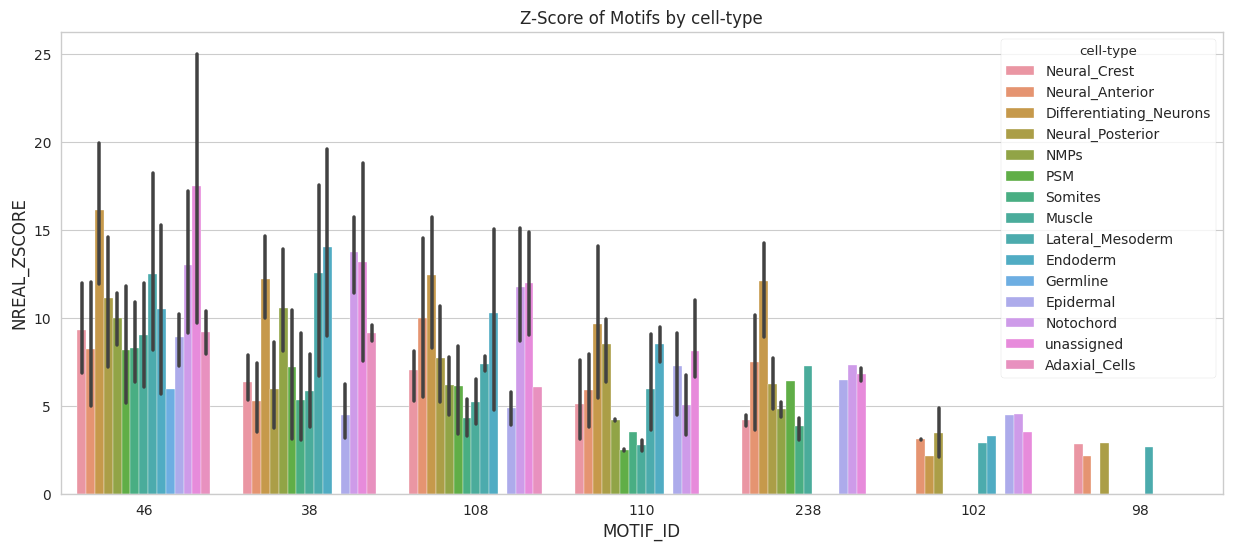

In [348]:
# A bar plot showing the Z-score of motifs for each motif for different timepoints
# convert the NREAL_ZSCORE fields from string to floats
df_motifs_all['NREAL_ZSCORE'] = pd.to_numeric(df_motifs_all['NREAL_ZSCORE'], errors='coerce')

# Example using 'timepoint' for coloring
plt.figure(figsize=(15, 6))  # Adjust size as necessary
sns.barplot(x='MOTIF_ID', y='NREAL_ZSCORE', hue='cell-type', data=df_motifs_all)
plt.title('Z-Score of Motifs by cell-type')
#plt.xticks(rotation=90)  # Rotate x-labels for better readability if necessary
plt.show()